# Clasificador de Imágenes Perro Vs. Gato

## Importar los paquetes a utilizar

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import tensorflow as tf

## Extraer los datos de la web

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
print(path_to_zip)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print("\n",path)

C:\Users\CAMILO\.keras\datasets\cats_and_dogs.zip

 C:\Users\CAMILO\.keras\datasets\cats_and_dogs_filtered


Estructura de la siguiente manera:

***cats_and_dogs_filtered***

training set

    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
validation set

    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')  # Directorio con training set de gatos
train_dogs_dir = os.path.join(train_dir, 'dogs')  # Directorio con training set de perros
validation_cats_dir = os.path.join(validation_dir, 'cats')  # Directorio con validation set de gatos
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # Directorio con validation set de perros

## Analizar la estructura de los datos

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('Número de imágenes de trainig set de gatos:', num_cats_tr)
print('Número de imágenes de trainig set de perros:', num_dogs_tr)

print('Número de imágenes de validation set de gatos:', num_cats_val)
print('Número de imágenes de validation set de perros:', num_dogs_val)
print("--")
print("Total de imágenes de entrenamiento:", total_train)
print("Total de imágenes de validación:", total_val)

Número de imágenes de trainig set de gatos: 1000
Número de imágenes de trainig set de perros: 1000
Número de imágenes de validation set de gatos: 500
Número de imágenes de validation set de perros: 500
--
Total de imágenes de entrenamiento: 2000
Total de imágenes de validación: 1000


Se ajustan variables para el pre-procesamiento de la NN

In [7]:
batch_size = 153  #es el número de ejemplos usados en una iteración
epochs = 13       #son las veces que se entrena una NN (iteraciones)
IMG_HEIGHT = 150  #se predefine el tamaño para todas las imágenes
IMG_WIDTH = 150   

## Preparación de los datos

Se deben preparar los datos para que sean homogéneos y con la misma estructura. Para esto se debe:



1.   Acceder a los archivos en memoria
2.   Decodificar el contenido y convertirlo en una matriz con formato RGB

Con TF2 tenemos instalado el paquete `tf.keras`, del cual usamos `ImageDataGenerator`

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator para los datos de entrenamiento
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator para los datos de validación

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size, #Tamaño de batch#
                                                           directory = train_dir,   #Ubicación del directorio#
                                                           shuffle = True,          #Aleatorio#
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH), #Tamaño de las imágenes#
                                                           class_mode = 'binary')   #Tipo de clasificación (binaria)#

Found 2000 images belonging to 2 classes.


Se hace con el validation set también

In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


## Visualizar las imágenes

* Es importante siempre conocer con lo que estamos trabajando
* En este caso usaremos `matplotlib` para la visualización
* La función `next` regresa un lote (32 en este caso). Esta función regresa 2 resultados de la forma `(x_train, y_train)`, donde `x_train` son las imágenes y `y_train` son las etiquetas. En este caso, sólo necesitamos las imágenes.


In [11]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [12]:
# Esta función va a graficar las imágenes en forma de malla, con 2 filas y 4 columnas
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

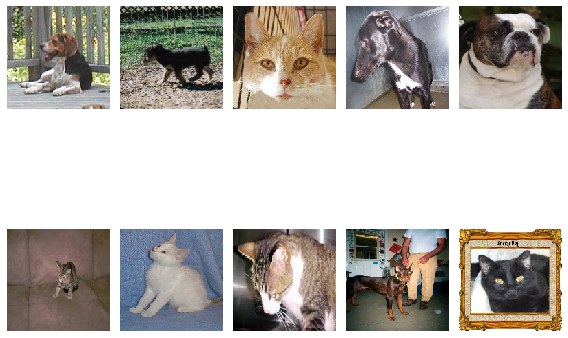

In [13]:
plotImages(sample_training_images[:10])

## Crear el modelo

Este ejemplo se usará un `Sequential` para secuenciar 3 capas de convolución, cada una seguida por una capa de MaxPooling. 
Finalmente, se usa una capa `Dense` con función de activación `relu`

In [14]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)])  

### MaxPooling

!["Max Pooling"](https://cdn-images-1.medium.com/freeze/max/1000/1*GksqN5XY8HPpIddm5wzm7A.jpeg?q=20)

## Compilar el modelo

* El estándar suele ser el optimizador "ADAM".
* Para este ejemplo se usará la función de costo (loss function) `binary cross entropy`
* Queremos que nos entregue como resultado de cada iteración la precisión `accuracy`

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Resumen del modelo

Para ver todas las capas de la NN usamos el método `summary`

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

## Entrenar el modelo

In [17]:
import warnings
warnings.filterwarnings("ignore")

Se usará el método `fit_generator` de la clase `ImageDataGenerator` para entrenar la NN

In [18]:
history = model.fit(
    train_data_gen, 
    steps_per_epoch = total_train // batch_size,
    #epochs = 2,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps = total_val // batch_size
)

Epoch 1/13
13/13 [==============================] - 68s 5s/step - loss: 1.4566 - accuracy: 0.5100 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 2/13
13/13 [==============================] - 67s 5s/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6892 - val_accuracy: 0.4967
Epoch 3/13
13/13 [==============================] - 71s 5s/step - loss: 0.6892 - accuracy: 0.4992 - val_loss: 0.6899 - val_accuracy: 0.5044
Epoch 4/13
13/13 [==============================] - 61s 5s/step - loss: 0.6786 - accuracy: 0.5030 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 5/13
13/13 [==============================] - 55s 4s/step - loss: 0.6692 - accuracy: 0.5436 - val_loss: 0.6632 - val_accuracy: 0.5044
Epoch 6/13
13/13 [==============================] - 64s 5s/step - loss: 0.6409 - accuracy: 0.5853 - val_loss: 0.6235 - val_accuracy: 0.6111
Epoch 7/13
13/13 [==============================] - 80s 6s/step - loss: 0.6128 - accuracy: 0.6264 - val_loss: 0.6338 - val_accuracy: 0.6732
Epoch 8/13
13/13 [==

## Resultados de entrenamiento del modelo

predictions_train = model.predict_classes(train_data_gen, verbose=True)

predictions_val = model.predict_classes(val_data_gen, verbose = True)

In [19]:
model.evaluate(train_data_gen)

14/14 [==============================] - 27s 2s/step - loss: 0.4089 - accuracy: 0.8170


[0.40887320041656494, 0.8169999718666077]

In [20]:
model.evaluate(val_data_gen)

7/7 [==============================] - 9s 1s/step - loss: 0.5549 - accuracy: 0.7190


[0.5549489855766296, 0.718999981880188]

___________________________________________

Este algoritmo puede mejorar. Tiene overfitting y hay que considerar las variaciones de las imágenes de entrenamiento

Tomado de *https://www.tensorflow.org/tutorials/images/classification*